# Example 3: Tile2Vec features for CDL classification
In this notebook, we'll use a Tile2Vec model that has been pre-trained on the NAIP dataset to embed a small NAIP dataset and then train a classifier on the corresponding Cropland Data Layer (CDL) labels.

In [159]:
import numpy as np
import os
import torch
from time import time
from torch.autograd import Variable

import sys
sys.path.append('../')
from src.tilenet import make_tilenet
from src.resnet import ResNet18

## Step 1. Loading pre-trained model
In this step, we will initialize a new TileNet model and then load the pre-trained weights.

In [160]:
# Setting up model
in_channels = 4
z_dim = 512
cuda = torch.cuda.is_available()
tilenet = make_tilenet(in_channels=in_channels, z_dim=z_dim)
# Use old model for now
tilenet = ResNet18()
if cuda: tilenet.cuda()

In [161]:
# Load parameters
#model_fn = '../models/naip_trained.ckpt'
model_fn = '../models/naip_trained.ckpt'
checkpoint = torch.load(model_fn, map_location=torch.device('cpu'))
tilenet.load_state_dict(checkpoint)
tilenet.eval()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

## Step 2. Embed NAIP tiles
In this step, we'll use TileNet to embed the NAIP tiles provided in `tile2vec/data/tiles`. There are 1000 tiles in total, named `1tile.npy` through `1000tile.npy`.

In [162]:
# Get data
tile_dir = '../data/tiles'
tile_dir = '../data/new_tiles/' 
tile_dir = '../data/toa_test_tiles/'
n_tiles = 20277
y = np.load(os.path.join(tile_dir, 'y.npy'))
print(y.shape)

(20278,)


## Tile2Vec

In [163]:
# Embed tiles
t0 = time()
X_t2v = np.zeros((n_tiles, z_dim))
for idx in range(n_tiles):
    tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx))) #used to bbe idx+1 so undo if error
    # Get first 4 ≠ 3 NAIP channels (5th is CDL mask)
    tile = tile[:,:,:4]
    # Rearrange to PyTorch order
    tile = np.moveaxis(tile, -1, 0)
    tile = np.expand_dims(tile, axis=0)
    # Scale to [0, 1]
    #tile = tile / 255
    # Embed tile
    
    # Add 4th feature to each pixel for ResNet structure
    new_col = np.full((1,1,51, 51), 0)
    tile = np.append(tile, new_col, axis=1)
    
    tile = torch.from_numpy(tile).float()
    tile = Variable(tile)
    
    if cuda: tile = tile.cuda()
        
    z = tilenet.encode(tile)
    
    if cuda: z = z.cpu()
        
    z = z.data.numpy()
    X_t2v[idx,:] = z
    
t1 = time()
print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))
print ('Example time: 6.006s \nMy time: 1408.367s')

Embedded 20277 tiles: 1667.152s
Example time: 6.006s 
My time: 1408.367s


## ResNet 18

In [144]:
from img2vec_pytorch import Img2Vec
import numpy as np
import os
from PIL import Image
from matplotlib import cm
from time import time

In [145]:
# Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=False)


t0 = time()
X_res18 = np.zeros((n_tiles, z_dim))
for idx in range(n_tiles):

    # Read in an image
    tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx)))
    
    im = Image.fromarray((tile * 255).astype(np.uint8))   
    
    vec = img2vec.get_vec(im, tensor=True)
    
    new_vec = [x for x in vec[0]]

    X_res18[idx, :] = new_vec
    
    if (idx % 1000 == 0):
        print ("Progress: {:.2f}%".format(idx/n_tiles*100))
        
t1 = time()
print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))

<ipython-input-145-49b9a49e57b1>:18: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_res18[idx, :] = new_vec


Progress: 0.00%


KeyboardInterrupt: 

## ResNet 34

In [152]:
resnet34 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx)))

tile = torch.tensor(tile)

with torch.no_grad():
    
    output = resnet34(tile)

Using cache found in /Users/calummcmeekin/.cache/torch/hub/pytorch_vision_v0.6.0


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [51, 51, 3] instead

In [148]:
# Initialize Img2Vec with GPU
img2vec = Img2Vec(model = 'resnet-18', cuda=False)


t0 = time()
X_res34 = np.zeros((n_tiles, 512))

for idx in range(n_tiles):

    # Read in an image
    tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx)))
    
    im = Image.fromarray((tile * 255).astype(np.uint8))   
    
    vec = img2vec.get_vec(im, tensor=True)
    
    new_vec = [x for x in vec[0]]

    X_res34[idx, :] = new_vec
    
    if (idx % 1000 == 0):
        print ("Progress: {:.2f}%".format(idx/n_tiles*100))
        
t1 = time()
print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))

<ipython-input-148-f9d9789213c7>:19: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_res34[idx, :] = new_vec


ValueError: could not broadcast input array from shape (512,) into shape (4096,)

## AlexNet

In [129]:
# Initialize Img2Vec with GPU
img2vec = Img2Vec(model = 'alexnet', cuda=False)


t0 = time()
X_alex = np.zeros((n_tiles, 4096))

for idx in range(n_tiles):

    # Read in an image
    tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx)))
    
    im = Image.fromarray((tile * 255).astype(np.uint8))   
    
    vec = img2vec.get_vec(im, tensor=True)
    
    new_vec = [x for x in vec[0]]

    X_alex[idx, :] = new_vec
    
    if (idx % 1000 == 0):
        print ("Progress: {:.2f}%".format(idx/n_tiles*100))
        
t1 = time()
print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))

Progress: 0.00%
Progress: 4.93%
Progress: 9.86%
Progress: 14.80%
Progress: 19.73%
Progress: 24.66%
Progress: 29.59%
Progress: 34.52%
Progress: 39.45%
Progress: 44.39%
Progress: 49.32%
Progress: 54.25%
Progress: 59.18%
Progress: 64.11%
Progress: 69.04%
Progress: 73.98%
Progress: 78.91%
Progress: 83.84%
Progress: 88.77%
Progress: 93.70%
Progress: 98.63%
Embedded 20277 tiles: 1623.597s


## Step 3. Train random forest classifier
In this step, we'll split the dataset into train and test sets and train a random forest classifier to predict CDL classes.

In [134]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [115]:
X = X_t2v
#X = X_res18
#X = X_alex

In [116]:
# Check CDL classes
print(set(y))
print (len(X[0]))

{0, 1, 2}
512


Since the CDL classes are not numbered in consecutive order, we'll start by reindexing the classes from 0.

In [117]:
# Reindex CDL classes
y = LabelEncoder().fit_transform(y)
print(set(y))
print (len(y[0:-1]))
print (X[0])

{0, 1, 2}
20277
[2.07926966e-02 9.03896332e-01 5.23346090e+00 3.81768775e+00
 4.55879122e-01 8.23411942e-01 4.69019175e+00 3.18325073e-01
 1.64662015e+00 2.75191851e-03 3.88235509e-01 1.11445498e+00
 2.14579090e-01 1.37977159e+00 1.68092251e-01 4.39717627e+00
 0.00000000e+00 2.51095343e+00 4.59684753e+00 6.79904670e-02
 1.31575239e+00 9.42820832e-02 6.37903154e-01 5.48112297e+00
 5.18632221e+00 3.15330744e+00 1.76793003e+00 7.62342364e-02
 1.99975491e-01 7.62434125e-01 4.04481554e+00 3.22980475e+00
 1.42447555e+00 2.47234419e-01 0.00000000e+00 2.32348107e-02
 2.50813752e-01 9.04502869e-01 2.77597332e+00 4.13479614e+00
 1.21747471e-01 9.25319076e-01 7.30534315e-01 0.00000000e+00
 1.01086862e-01 2.97820270e-02 0.00000000e+00 4.33424139e+00
 3.95916849e-02 5.72143495e-01 1.44532859e+00 2.91013092e-01
 1.31669892e-02 4.30459157e-02 1.79438663e+00 1.65119305e-01
 1.26446709e-01 1.04708421e+00 9.05469805e-02 4.46718000e-03
 5.02740240e+00 1.21430419e-01 0.00000000e+00 1.40885770e+00
 1.12194

We can randomly split the data and train a random forest classifier many times to get an estimate of the average accuracy.

In [118]:
n_trials = 100
accs = np.zeros((n_trials,))
precisions = np.zeros((n_trials,))
recalls = np.zeros((n_trials,))
fscores = np.zeros((n_trials,))
for i in range(n_trials):
    # Splitting data and training RF classifer
    X_tr, X_te, y_tr, y_te = train_test_split(X, y[0:-1], test_size=0.2)
    rf = RandomForestClassifier()
    rf.fit(X_tr, y_tr)
    accs[i] = rf.score(X_te, y_te)
    y_pred = rf.predict(X_te)
    precisions[i], recalls[i], fscores[i], _ = precision_recall_fscore_support(y_te, y_pred, average='macro')
    
print ("____Accuracy____")
print('Mean accuracy: {:0.4f}'.format(accs.mean()))
print('Standard deviation: {:0.4f}'.format(accs.std()))

print ("____Macro Precision____")
print('Mean macro precision: {:0.4f}'.format(precisions.mean()))
print('Standard deviation: {:0.4f}'.format(precisions.std()))

print ("____Macro Recall____")
print('Mean macro recall: {:0.4f}'.format(recalls.mean()))
print('Standard deviation: {:0.4f}'.format(recalls.std()))

print ("____Macro F1-Score____")
print('Mean macro F1-Score: {:0.4f}'.format(fscores.mean()))
print('Standard deviation: {:0.4f}'.format(fscores.std()))



____Accuracy____
Mean accuracy: 0.8686
Standard deviation: 0.0053
____Macro Precision____
Mean macro precision: 0.8702
Standard deviation: 0.0053
____Macro Recall____
Mean macro recall: 0.8685
Standard deviation: 0.0052
____Macro F1-Score____
Mean macro F1-Score: 0.8689
Standard deviation: 0.0052


### Results

---
#### Tile2Vec 

____Accuracy____

Mean accuracy: 0.7878

Standard deviation: 0.0060

____Macro Precision____

Mean macro precision: 0.7863

Standard deviation: 0.0057

____Macro Recall____

Mean macro recall: 0.7874

Standard deviation: 0.0057

____Macro F1-Score____

Mean macro F1-Score: 0.7899

Standard deviation: 0.0058

---
#### Tile2Vec Pre-Trained on NAIP

____Accuracy____

Mean accuracy: 0.8686

Standard deviation: 0.0053

____Macro Precision____

Mean macro precision: 0.8702

Standard deviation: 0.0053

____Macro Recall____

Mean macro recall: 0.8685

Standard deviation: 0.0052

____Macro F1-Score____

Mean macro F1-Score: 0.8689

Standard deviation: 0.0052

---
#### ResNet 18

____Accuracy____

Mean accuracy: 0.8812

Standard deviation: 0.0043

____Macro Precision____

Mean macro precision: 0.8824

Standard deviation: 0.0049

____Macro Recall____

Mean macro recall: 0.8811

Standard deviation: 0.0048

____Macro F1-Score____

Mean macro F1-Score: 0.8814

Standard deviation: 0.0048

---
#### AlexNet

____Accuracy____

Mean accuracy: 0.9042

Standard deviation: 0.0043

____Macro Precision____

Mean macro precision: 0.9056

Standard deviation: 0.0042

____Macro Recall____

Mean macro recall: 0.9041

Standard deviation: 0.0043

____Macro F1-Score____

Mean macro F1-Score: 0.9043

Standard deviation: 0.0043


Achieved 67% 0.0068 Std Dev. accuracy on TileNet_epoch100_normalised_data model with 20,000 roughly TOA test set

Achieved 78.84%, 0.0055 Std Dev. accuracy on TileNet_epoch99_toa_data model with roughly 20,000 TOA test set

## Use KNN Classifier

In [171]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import math

In [165]:
X = X_t2v
#X = X_res18
#X = X_alex

In [173]:
print (len(X))
N = math.floor(np.sqrt(len(X)))

20277


In [176]:
# Calculate optimal value of K

error_rate = []

X_tr, X_te, y_tr, y_te = train_test_split(X, y[0:-1], test_size=0.2)

for i in range(1,N+10,15):
    print (" K = {} ".format(i))
    #knn = KNeighborsClassifier(n_neighbors=i)
    
    #knn.fit(X_tr,y_tr)
    
    #pred_i = knn.predict(X_te)
    
    #error_rate.append(np.mean(pred_i != y_te))

 K = 1 
 K = 16 
 K = 31 
 K = 46 
 K = 61 
 K = 76 
 K = 91 
 K = 106 
 K = 121 
 K = 136 
 K = 151 


In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)

plt.title('Error Rate vs. K Value')

plt.xlabel('K')

plt.ylabel('Error Rate')

print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [157]:
n_trials = 100

accs = np.zeros((n_trials,))
precisions = np.zeros((n_trials,))
recalls = np.zeros((n_trials,))
fscores = np.zeros((n_trials,))



for i in range(n_trials):
    print ("\rProgress: {:.2f}%".format(i))
    # Splitting data and training RF classifer
    X_tr, X_te, y_tr, y_te = train_test_split(X, y[0:-1], test_size=0.2)
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_tr, y_tr)
    accs[i] = knn.score(X_te, y_te)
    y_pred = knn.predict(X_te)
    precisions[i], recalls[i], fscores[i], _ = precision_recall_fscore_support(y_te, y_pred, average='macro')
    
    
    
    
print ("____Accuracy____")
print('Mean accuracy: {:0.4f}'.format(accs.mean()))
print('Standard deviation: {:0.4f}'.format(accs.std()))

print ("____Macro Precision____")
print('Mean macro precision: {:0.4f}'.format(precisions.mean()))
print('Standard deviation: {:0.4f}'.format(precisions.std()))

print ("____Macro Recall____")
print('Mean macro recall: {:0.4f}'.format(recalls.mean()))
print('Standard deviation: {:0.4f}'.format(recalls.std()))

print ("____Macro F1-Score____")
print('Mean macro F1-Score: {:0.4f}'.format(fscores.mean()))
print('Standard deviation: {:0.4f}'.format(fscores.std()))




Progress: 0.00%
Progress: 1.00%
Progress: 2.00%
Progress: 3.00%
Progress: 4.00%
Progress: 5.00%


KeyboardInterrupt: 

## Step 5. Visualise the data

In [139]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [140]:
N = 10000

data_subset = X[:N].copy()
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


ValueError: Length of values (10000) does not match length of index (20277)

In [141]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300) #n_components = 512

tsne_results = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20277 samples in 0.056s...
[t-SNE] Computed neighbors for 20277 samples in 54.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20277
[t-SNE] Computed conditional probabilities for sample 2000 / 20277
[t-SNE] Computed conditional probabilities for sample 3000 / 20277
[t-SNE] Computed conditional probabilities for sample 4000 / 20277
[t-SNE] Computed conditional probabilities for sample 5000 / 20277
[t-SNE] Computed conditional probabilities for sample 6000 / 20277
[t-SNE] Computed conditional probabilities for sample 7000 / 20277
[t-SNE] Computed conditional probabilities for sample 8000 / 20277
[t-SNE] Computed conditional probabilities for sample 9000 / 20277
[t-SNE] Computed conditional probabilities for sample 10000 / 20277
[t-SNE] Computed conditional probabilities for sample 11000 / 20277
[t-SNE] Computed conditional probabilities for sample 12000 / 20277
[t-SNE] Computed conditional probabilities for s

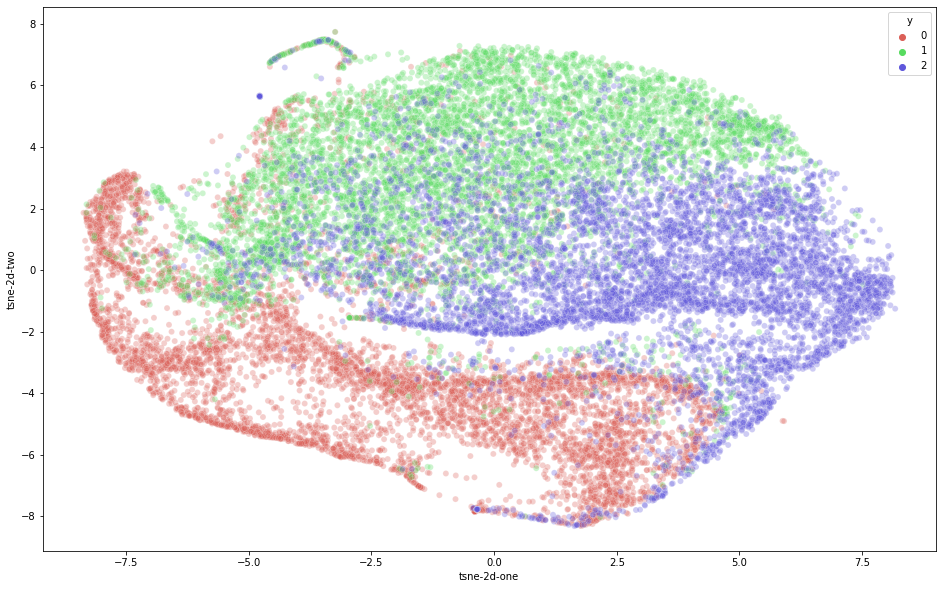

In [142]:
df_subset = pd.DataFrame()
df_subset['y'] = y[:-1]
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=df_subset,
    legend="full",
    alpha=0.3
)

plt.savefig('../figures/tsne_toa_alexnet')

## Convert arrays to seed positions for Visualisation on map

In [189]:
def seed_generator(arr):
    ama_seeds = []
    cat_seeds = []
    cer_seeds = []
    
    cur_pos = 0
    
    for pred_class in arr:
        
        if (pred_class) == 0:
            ama_seeds.append(cur_pos)
        elif (pred_class) == 1:
            cat_seeds.append(cur_pos)
        elif (pred_class) == 2:
            cer_seeds.append(cur_pos)
            
        cur_pos += 1
    return ama_seeds, cat_seeds, cer_seeds

In [190]:
ama_seeds, cat_seeds, cer_seeds = seed_generator(y_pred)

In [192]:
print (ama_seeds)

[0, 1, 3, 4, 5, 10, 13, 14, 15, 16, 19, 21, 25, 31, 32, 33, 34, 40, 41, 43, 46, 47, 48, 50, 52, 53, 57, 58, 60, 61, 64, 65, 70, 79, 85, 89, 90, 95, 98, 100, 101, 103, 105, 108, 112, 125, 126, 130, 131, 154, 156, 157, 158, 159, 160, 162, 166, 174, 180, 181, 183, 198, 201, 203, 204, 210, 212, 213, 218, 219, 226, 227, 228, 229, 235, 238, 240, 242, 244, 248, 253, 259, 262, 264, 267, 269, 270, 272, 277, 278, 279, 281, 282, 283, 286, 287, 291, 294, 296, 301, 303, 305, 310, 313, 314, 315, 318, 321, 324, 329, 334, 335, 337, 340, 346, 349, 350, 356, 359, 360, 363, 364, 369, 372, 373, 375, 379, 381, 387, 388, 389, 391, 394, 398, 401, 403, 405, 408, 409, 411, 420, 423, 425, 431, 434, 435, 437, 438, 439, 443, 446, 447, 448, 452, 458, 465, 467, 472, 475, 477, 482, 485, 486, 489, 490, 494, 495, 496, 501, 507, 508, 510, 516, 525, 529, 535, 540, 541, 543, 545, 546, 550, 554, 557, 558, 561, 563, 565, 566, 567, 568, 574, 575, 579, 580, 581, 582, 586, 587, 590, 591, 592, 596, 597, 598, 600, 603, 605, 606

[0 0 1 ... 1 0 2]
